In [1]:
#!pip install shap

In [2]:
#pip install --upgrade pip


In [3]:
#!pip install toad

In [4]:
import toad

In [5]:
import pandas as pd
import numpy as np
import shap
#import shapely
from sklearn.model_selection import train_test_split


In [6]:
account = pd.read_csv(r"C:\Users\dmariru\OneDrive - KPMG\Documents\Data\frm\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\account.csv", sep = ';')
card = pd.read_csv(r"C:\Users\dmariru\OneDrive - KPMG\Documents\Data\frm\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\card.csv", sep = ';')
client = pd.read_csv(r"C:\Users\dmariru\OneDrive - KPMG\Documents\Data\frm\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\client.csv", sep = ';')
disp = pd.read_csv(r"C:\Users\dmariru\OneDrive - KPMG\Documents\Data\frm\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\disp.csv", sep = ';')
district = pd.read_csv(r"C:\Users\dmariru\OneDrive - KPMG\Documents\Data\frm\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\district.csv", sep = ';')
loan = pd.read_csv(r"C:\Users\dmariru\OneDrive - KPMG\Documents\Data\frm\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\loan.csv", sep = ';')
order = pd.read_csv(r"C:\Users\dmariru\OneDrive - KPMG\Documents\Data\frm\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\order.csv", sep = ';')
trans = pd.read_csv(r"C:\Users\dmariru\OneDrive - KPMG\Documents\Data\frm\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\lpetrocelli-czech-financial-dataset-real-anonymized-transactions\trans.csv", sep = ';')

Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.


In [7]:
# Change some variables to English
account['frequency'] = account['frequency'].map({'POPLATEK MESICNE': 'Monthly Issuance', 'POPLATEK TYDNE': 'Weekly Issuance' ,'POPLATEK PO OBRATU':'issuance after transaction'  })
trans['type'] = trans['type'].map({'PRIJEM': 'Credit', 'VYDAJ': 'Withdrawal'})
trans['operation'] = trans['operation'].map({'VYBER ': 'withdrawal in cash', 'PREVOD NA UCET': 'remittance to another bank' ,'VKLAD':'Credit in cash' , 'PREVOD Z UCTU':'Collection from another bank','VYBER KARTOU':'Creditcard withdrawal' })                                               
order['k_symbol'] = order['k_symbol'].map({'SIPO': 'Household Payment', 'UVER': 'Loan Payment' ,'POJISTNE ':'Insurance Payment' , 'LEASING ':'Lease Payment' })                                                  

In [8]:
#Rename variables
account.rename(columns = {'date': 'account_date'}, inplace=True)
card.rename(columns = {'type': 'card_type'}, inplace=True)
card.rename(columns = {'issued': 'issued_date'}, inplace=True)
disp.rename(columns = {'type': 'disposition_type'}, inplace=True)
loan.rename(columns = {'date': 'loan_date'}, inplace=True)
loan.rename(columns = {'amount': 'loan_amount'}, inplace=True)
loan.rename(columns = {'duration': 'loan_duration'}, inplace=True)
trans.rename(columns = {'date': 'trans_date'}, inplace=True)
trans.rename(columns = {'amount': 'trans_amount'}, inplace=True)
trans.rename(columns = {'type': 'trans_type'}, inplace=True)
order.rename(columns = {'amount': 'order_amount'}, inplace=True)

In [9]:
#fill in missing values
#order = order.fillna(order.mode().iloc[0])
#trans['trans_type'] = trans['trans_type'].fillna(order.mode().iloc[0])


 

In [10]:
#null = (trans.isnull().sum()/trans.shape[0]) * 100
#null

In [11]:
#disp.head()
#disp['account_id'].nunique()
#disp.shape

In [12]:
#client.head()
#client['client_id'].nunique()
#client.shape

In [13]:
#card.head()
#card.shape
#card['disp_id'].nunique()

In [14]:
trans.head()

,trans_id,account_id,trans_date,trans_type,operation,trans_amount,balance,k_symbol,bank,account
0,695247,2378,930101,Credit,Credit in cash,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,Credit,Credit in cash,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,Credit,Credit in cash,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,Credit,Credit in cash,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,Credit,Credit in cash,400.0,400.0,NaN,NaN,NaN


In [15]:
transaction = trans.groupby(["account_id"], as_index=False)["trans_amount", "balance"].sum()
tally_trans = trans.groupby(["account_id" ], as_index=False)["trans_amount"].count()
transaction['frequency_transactions'] = tally_trans['trans_amount']
transaction.head()

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,account_id,trans_amount,balance,frequency_transactions
0,1,375174.5,3822568.0,239
1,2,3151479.3,17466456.7,478
2,3,295021.8,3155900.3,117
3,4,350971.4,4046141.0,186
4,5,166881.4,2107565.8,84


In [16]:
orders = order.groupby(["account_id"], as_index=False)["order_amount"].sum()
tally_order = order.groupby(["account_id" ], as_index=False)["order_amount"].count()
orders['frequency_orders'] = tally_order['order_amount']
orders.head()

,account_id,order_amount,frequency_orders
0,1,2452.0,1
1,2,10638.7,2
2,3,5001.0,3
3,4,3363.0,2
4,5,2668.0,1


In [17]:
#order[order['account_id'] == 3]

In [18]:
#orders['account_id'].nunique()

In [19]:
#orders.shape

In [20]:
order.shape

(6471, 6)

In [21]:
loan.head()

,loan_id,account_id,loan_date,loan_amount,loan_duration,payments,status
0,5314,1787,930705,96396,12,8033.0,B
1,5316,1801,930711,165960,36,4610.0,A
2,6863,9188,930728,127080,60,2118.0,A
3,5325,1843,930803,105804,36,2939.0,A
4,7240,11013,930906,274740,60,4579.0,A


In [22]:
loan['loan_id'].nunique()

682

In [23]:
loan.shape

(682, 7)

In [24]:
account.head()

,account_id,district_id,frequency,account_date
0,576,55,Monthly Issuance,930101
1,3818,74,Monthly Issuance,930101
2,704,55,Monthly Issuance,930101
3,2378,16,Monthly Issuance,930101
4,2632,24,Monthly Issuance,930102


In [25]:
account.shape

(4500, 4)

In [26]:
account['account_id'].nunique()

4500

In [27]:
#trans[trans['account_id'] == 1]

In [28]:
order.head()

,order_id,account_id,bank_to,account_to,order_amount,k_symbol
0,29401,1,YZ,87144583,2452.0,Household Payment
1,29402,2,ST,89597016,3372.7,Loan Payment
2,29403,2,QR,13943797,7266.0,Household Payment
3,29404,3,WX,83084338,1135.0,Household Payment
4,29405,3,CD,24485939,327.0,NaN


In [29]:
account.columns

Index(['account_id', 'district_id', 'frequency', 'account_date'], dtype='object')

In [30]:
card.columns

Index(['card_id', 'disp_id', 'card_type', 'issued_date'], dtype='object')

In [31]:
client.columns

Index(['client_id', 'birth_number', 'district_id'], dtype='object')

In [32]:
disp.columns

Index(['disp_id', 'client_id', 'account_id', 'disposition_type'], dtype='object')

In [33]:
loan.columns

Index(['loan_id', 'account_id', 'loan_date', 'loan_amount', 'loan_duration',
       'payments', 'status'],
      dtype='object')

In [34]:
trans.columns

Index(['trans_id', 'account_id', 'trans_date', 'trans_type', 'operation',
       'trans_amount', 'balance', 'k_symbol', 'bank', 'account'],
      dtype='object')

In [35]:
loan = pd.merge(loan , transaction, how='left', left_on='account_id', right_on='account_id')
loan = pd.merge(loan, orders ,how = 'left' ,left_on = 'account_id' , right_on ='account_id')
loan = pd.merge(loan , account, how='left', left_on='account_id', right_on='account_id')
#loan = pd.merge(loan, district ,how = 'left' ,left_on = 'district_id' , right_on ='district_id')
#loan = pd.merge(loan , disp, how='left', left_on='account_id', right_on= 'account_id')
#loan = pd.merge(loan, card ,how = 'left' ,left_on = 'disp_id' , right_on ='disp_id')

for col in loan:
    if col.endswith('_x'):
        loan.rename(columns = lambda col:col.rstrip('_x'),inplace=True)
    elif col.endswith('_y'):
        to_drop = [col for col in loan if col.endswith('_y')]
        loan.drop(to_drop,axis=1,inplace=True)
    else: 
        pass 

In [36]:
loan.head()

,loan_id,account_id,loan_date,loan_amount,loan_duration,payments,status,trans_amount,balance,frequency_transactions,order_amount,frequency_orders,district_id,frequency,account_date
0,5314,1787,930705,96396,12,8033.0,B,4108891.9,17838608.3,403,8033.2,1,30,Weekly Issuance,930322
1,5316,1801,930711,165960,36,4610.0,A,4751818.5,27535353.5,633,13152.0,4,46,Monthly Issuance,930213
2,6863,9188,930728,127080,60,2118.0,A,1961962.3,17818622.7,605,10591.3,4,45,Monthly Issuance,930208
3,5325,1843,930803,105804,36,2939.0,A,2764436.9,16479243.5,462,9932.7,2,12,Monthly Issuance,930130
4,7240,11013,930906,274740,60,4579.0,A,6376283.8,32497067.0,571,14834.0,3,1,Weekly Issuance,930214


In [37]:
#trans.shape

In [38]:
loan['loan_id'].nunique()

682

In [39]:
loan.shape

(682, 15)

In [40]:
import datetime as dt
loan['loan_date'] = pd.to_datetime(loan['loan_date'])
loan['loan_date'] = loan['loan_date'].dt.date
loan['loan_year'] = loan['loan_date'].apply(lambda x:x.year)
loan['loan_month'] = loan['loan_date'].apply(lambda x:x.month)


loan['account_date'] = pd.to_datetime(loan['account_date'])
loan['account_date'] = loan['account_date'].dt.date
loan.head()






,loan_id,account_id,loan_date,loan_amount,loan_duration,payments,status,trans_amount,balance,frequency_transactions,order_amount,frequency_orders,district_id,frequency,account_date,loan_year,loan_month
0,5314,1787,1970-01-01,96396,12,8033.0,B,4108891.9,17838608.3,403,8033.2,1,30,Weekly Issuance,1970-01-01,1970,1
1,5316,1801,1970-01-01,165960,36,4610.0,A,4751818.5,27535353.5,633,13152.0,4,46,Monthly Issuance,1970-01-01,1970,1
2,6863,9188,1970-01-01,127080,60,2118.0,A,1961962.3,17818622.7,605,10591.3,4,45,Monthly Issuance,1970-01-01,1970,1
3,5325,1843,1970-01-01,105804,36,2939.0,A,2764436.9,16479243.5,462,9932.7,2,12,Monthly Issuance,1970-01-01,1970,1
4,7240,11013,1970-01-01,274740,60,4579.0,A,6376283.8,32497067.0,571,14834.0,3,1,Weekly Issuance,1970-01-01,1970,1


In [41]:
loan = loan.drop(['loan_id','account_id'],axis = 1)

In [42]:
loan[:1]

,loan_date,loan_amount,loan_duration,payments,status,trans_amount,balance,frequency_transactions,order_amount,frequency_orders,district_id,frequency,account_date,loan_year,loan_month
0,1970-01-01,96396,12,8033.0,B,4108891.9,17838608.3,403,8033.2,1,30,Weekly Issuance,1970-01-01,1970,1


In [43]:
loan.columns

Index(['loan_date', 'loan_amount', 'loan_duration', 'payments', 'status',
       'trans_amount', 'balance', 'frequency_transactions', 'order_amount',
       'frequency_orders', 'district_id', 'frequency', 'account_date',
       'loan_year', 'loan_month'],
      dtype='object')

In [44]:
data = loan.copy()

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 681
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_date               682 non-null    object 
 1   loan_amount             682 non-null    int64  
 2   loan_duration           682 non-null    int64  
 3   payments                682 non-null    float64
 4   status                  682 non-null    object 
 5   trans_amount            682 non-null    float64
 6   balance                 682 non-null    float64
 7   frequency_transactions  682 non-null    int64  
 8   order_amount            682 non-null    float64
 9   frequency_orders        682 non-null    int64  
 10  district_id             682 non-null    int64  
 11  frequency               682 non-null    object 
 12  account_date            682 non-null    object 
 13  loan_year               682 non-null    int64  
 14  loan_month              682 non-null    in

In [46]:
from sklearn.preprocessing import LabelEncoder
#data = data.apply(LabelEncoder().fit_transform)

In [47]:
data.columns

Index(['loan_date', 'loan_amount', 'loan_duration', 'payments', 'status',
       'trans_amount', 'balance', 'frequency_transactions', 'order_amount',
       'frequency_orders', 'district_id', 'frequency', 'account_date',
       'loan_year', 'loan_month'],
      dtype='object')

In [48]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
data['status'] = labelencoder.fit_transform(data['status'])

In [49]:
data.head()

,loan_date,loan_amount,loan_duration,payments,status,trans_amount,balance,frequency_transactions,order_amount,frequency_orders,district_id,frequency,account_date,loan_year,loan_month
0,1970-01-01,96396,12,8033.0,1,4108891.9,17838608.3,403,8033.2,1,30,Weekly Issuance,1970-01-01,1970,1
1,1970-01-01,165960,36,4610.0,0,4751818.5,27535353.5,633,13152.0,4,46,Monthly Issuance,1970-01-01,1970,1
2,1970-01-01,127080,60,2118.0,0,1961962.3,17818622.7,605,10591.3,4,45,Monthly Issuance,1970-01-01,1970,1
3,1970-01-01,105804,36,2939.0,0,2764436.9,16479243.5,462,9932.7,2,12,Monthly Issuance,1970-01-01,1970,1
4,1970-01-01,274740,60,4579.0,0,6376283.8,32497067.0,571,14834.0,3,1,Weekly Issuance,1970-01-01,1970,1


In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [51]:
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33)
#X_train.shape , y_train.shape ,X_test.shape ,y_test.shape

In [52]:
#regression = LinearRegression()
#regression.fit(X_train,y_train)

In [53]:
#regressor  = RandomForestRegressor()
#regressor.fit(X_train,y_train)

In [54]:
#explainer = shap.TreeExplainer(regressor)
#shap_values = explainer.shap_values(X_train)

In [55]:
#shap.summary_plot(shap_values , X_train   , plot_type = "bar")

In [56]:
#shap.summary_plot(shap_values , X_train )

In [57]:
#shap.dependence_plot("total_acc",shap_values ,X_train )

In [58]:
#X_output = X_test.copy()
#X_output.loc[:,'predict'] = np.round(regressor.predict(X_output),2)

# Randomly pick some observations

#random_picks = np.arange(1,330,50) # Every 50 rows
#S = X_output.iloc[random_picks]
#S

In [59]:
#shap.initjs()

# Write in a function
#def shap_plot(j):
 #   explainerModel = shap.TreeExplainer(regressor)
  #  shap_values_Model = explainerModel.shap_values(S)
   # p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
   # return(p)


#shap_plot(0)

In [60]:
#X_train.mean()

In [61]:
data.shape

(682, 15)

In [62]:
train = data.iloc[0:450]
test = data.iloc[450:682]

In [63]:
test.head()

,loan_date,loan_amount,loan_duration,payments,status,trans_amount,balance,frequency_transactions,order_amount,frequency_orders,district_id,frequency,account_date,loan_year,loan_month
450,1970-01-01,68124,12,5677.0,0,1150134.0,6075188.9,162,13874.0,2,74,Monthly Issuance,1970-01-01,1970,1
451,1970-01-01,405780,60,6763.0,2,1114248.9,10110628.1,316,12006.0,4,62,Monthly Issuance,1970-01-01,1970,1
452,1970-01-01,57360,12,4780.0,1,1674910.2,6875015.5,249,12032.0,4,6,Monthly Issuance,1970-01-01,1970,1
453,1970-01-01,289920,48,6040.0,2,2069950.6,10007992.7,154,6039.8,1,33,Monthly Issuance,1970-01-01,1970,1
454,1970-01-01,97392,12,8116.0,0,2071077.3,11216483.4,203,14443.2,2,70,Monthly Issuance,1970-01-01,1970,1


In [64]:
train.head()

,loan_date,loan_amount,loan_duration,payments,status,trans_amount,balance,frequency_transactions,order_amount,frequency_orders,district_id,frequency,account_date,loan_year,loan_month
0,1970-01-01,96396,12,8033.0,1,4108891.9,17838608.3,403,8033.2,1,30,Weekly Issuance,1970-01-01,1970,1
1,1970-01-01,165960,36,4610.0,0,4751818.5,27535353.5,633,13152.0,4,46,Monthly Issuance,1970-01-01,1970,1
2,1970-01-01,127080,60,2118.0,0,1961962.3,17818622.7,605,10591.3,4,45,Monthly Issuance,1970-01-01,1970,1
3,1970-01-01,105804,36,2939.0,0,2764436.9,16479243.5,462,9932.7,2,12,Monthly Issuance,1970-01-01,1970,1
4,1970-01-01,274740,60,4579.0,0,6376283.8,32497067.0,571,14834.0,3,1,Weekly Issuance,1970-01-01,1970,1


In [65]:
print(train.shape ,test.shape)

(450, 15) (232, 15)


In [66]:
toad.detect(train)[:14]

,type,size,missing,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
loan_date,object,450,0.00%,1,1970-01-01:100.00%,None,None,NaN,NaN,NaN,NaN,None,None,1970-01-01:100.00%
loan_amount,int64,450,0.00%,431,145937.973333,107073.981119,4980.0,14904.360,34513.20,106374.00,2.028330e+05,301136.4,464801.52,538500.0
loan_duration,int64,450,0.00%,5,36.293333,17.090437,12.0,12.000,12.00,36.00,4.800000e+01,60.0,60.0,60.0
payments,float64,450,0.00%,399,4144.366667,2212.063531,312.0,460.950,1353.80,3878.50,5.919250e+03,7252.2,9124.43,9910.0
status,int32,450,0.00%,4,1.164444,1.057196,0.0,0.000,0.00,2.00,2.000000e+00,2.0,3.0,3.0
trans_amount,float64,450,0.00%,450,2789679.457111,1534278.922493,375719.6,542491.426,1006200.20,2486653.20,3.756890e+06,5045120.28,6924198.257,7399357.6
balance,float64,450,0.00%,450,15483415.176,7885262.029725,2188003.2,2946561.331,6195527.81,14174472.55,2.060273e+07,26740521.17,37171442.634,41213152.8
frequency_transactions,int64,450,0.00%,282,342.54,124.318111,80.0,127.490,189.00,336.00,4.287500e+02,502.9,635.53,675.0
order_amount,float64,450,0.00%,438,8844.910222,4791.538845,312.0,1203.950,3032.27,7943.15,1.204275e+04,15877.2,20070.273,21322.2
frequency_orders,int64,450,0.00%,5,2.206667,1.189954,1.0,1.000,1.00,2.00,3.000000e+00,4.0,5.0,5.0


In [67]:
toad.quality(data,'status',iv_only=True)[:15]


,iv,gini,entropy,unique
frequency_orders,0.944120,NaN,NaN,5.0
loan_amount,0.854304,NaN,NaN,645.0
order_amount,0.673020,NaN,NaN,649.0
trans_amount,0.593926,NaN,NaN,682.0
balance,0.568844,NaN,NaN,682.0
frequency_transactions,0.392584,NaN,NaN,356.0
district_id,0.378572,NaN,NaN,77.0
payments,0.355424,NaN,NaN,577.0
frequency,0.092372,NaN,NaN,3.0
loan_duration,0.092175,NaN,NaN,5.0


In [68]:
train_selected, dropped = toad.selection.select(train ,target = 'status', empty = 0.05, iv = 0.05, corr = 0.7, return_drop=True)#exclude = ['loan_date','account_date'])
print(dropped)
print(train_selected.shape)

{'empty': array([], dtype=float64), 'iv': array(['loan_date', 'account_date', 'loan_year', 'loan_month'],
      dtype=object), 'corr': array(['balance'], dtype=object)}
(450, 10)


In [69]:
train_selected.columns

Index(['loan_amount', 'loan_duration', 'payments', 'status', 'trans_amount',
       'frequency_transactions', 'order_amount', 'frequency_orders',
       'district_id', 'frequency'],
      dtype='object')

In [70]:
# initialise
c = toad.transform.Combiner()
#to_drop=['issue_d','earliest_cr_line','address']

# Train binning with the selected features from previous; use reliable Chi-squared binning, and control that each bucket has at least 5% sample.
c.fit(train_selected, y = 'status', method = 'chi', min_samples = 0.05) #exclude = to_drop) #empty_separate = False

# For the demonstration purpose, only showcase 3 bin results.


<AxesSubplot:xlabel='loan_amount', ylabel='prop'>

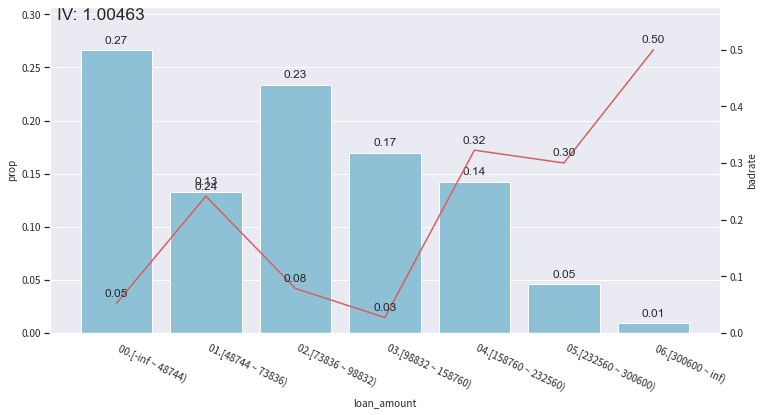

In [71]:
from toad.plot import bin_plot

# Check the bin results of 'var_d2' of in-sample
col = 'loan_amount'

# It's recommended to set 'labels = True' for better visualisation.
bin_plot(c.transform(train_selected[[col,'status']], labels=True), x=col, target='status')

In [72]:
from toad.plot import badrate_plot

col = 'trans_amount'

# Check the stability of 'var_d2''s bins across time
#badrate_plot(c.transform(train[[col,'target','month']], labels=True), target='target', x='month', by=col)
#badrate_plot(c.transform(OOT[[col,'target','month']], labels=True), target='target', x='month', by=col)

#badrate_plot(c.transform(data[[col,'target','month']], labels=True), target='target', x='month', by=col)
'''
A feature is preferrable if the gaps between classes get wider as time goes by - it means the binned classes have larger difference. No line crossing means the bin results are stable.
'''

'\nA feature is preferrable if the gaps between classes get wider as time goes by - it means the binned classes have larger difference. No line crossing means the bin results are stable.\n'

<AxesSubplot:xlabel='trans_amount', ylabel='prop'>

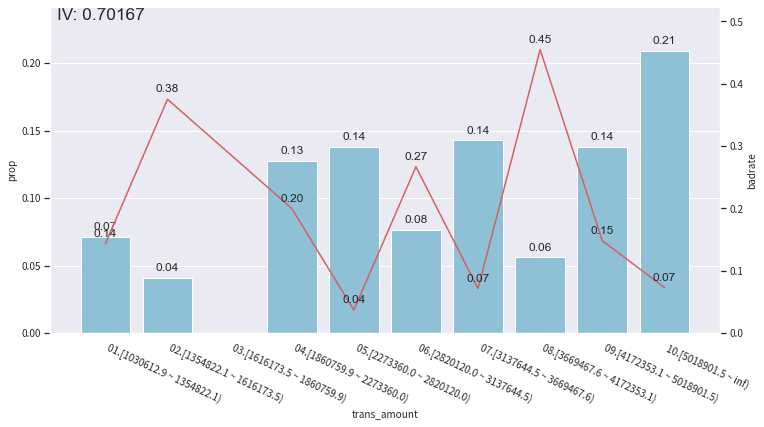

In [73]:
# Check the bin results of var_d5 of in-sample
col = 'trans_amount'

# It's recommended to set 'labels = True' for categorical features.
bin_plot(c.transform(train_selected[[col,'status']], labels=True), x=col, target='status')

In [74]:
# Initialise
transer = toad.transform.WOETransformer()

# transer.fit_transform() & combiner.transform(). Remember to exclude target
train_woe = transer.fit_transform(c.transform(train_selected), train_selected['status'] ,exclude=['status'])
OOT_woe = transer.transform(c.transform(test))

print(train_woe.head(3))

   loan_amount  loan_duration  payments  status  trans_amount  \
0    -0.589402      -0.415555  1.181304       1      1.692130   
1     1.132514       0.354625 -0.850128       0      0.125251   
2    -1.709068       0.775839  0.460758       0      0.488157   

   frequency_transactions  order_amount  frequency_orders  district_id  \
0                1.075943      0.575168          0.824629     0.041870   
1               -1.421386     -0.610455         -0.523444    -1.121281   
2               -1.421386     -1.383645         -0.523444    -1.121281   

   frequency  
0   0.488157  
1  -0.186062  
2  -0.186062  


In [75]:
train_woe.head()

,loan_amount,loan_duration,payments,status,trans_amount,frequency_transactions,order_amount,frequency_orders,district_id,frequency
0,-0.589402,-0.415555,1.181304,1,1.692130,1.075943,0.575168,0.824629,0.041870,0.488157
1,1.132514,0.354625,-0.850128,0,0.125251,-1.421386,-0.610455,-0.523444,-1.121281,-0.186062
2,-1.709068,0.775839,0.460758,0,0.488157,-1.421386,-1.383645,-0.523444,-1.121281,-0.186062
3,-1.709068,0.354625,0.460758,0,-1.383645,0.305835,-1.383645,-2.132882,0.049902,-0.186062
4,1.027153,0.775839,-0.850128,0,-0.664523,-1.421386,-0.099630,-0.153697,-0.492672,0.488157


In [76]:
# Apply stepwise regression on the WOE-transformed data
final_data = toad.selection.stepwise(train_woe,target = 'status', estimator='ols', direction = 'both', criterion = 'aic')# exclude = to_drop)

#  Place the selected features to test / OOT sample
final_OOT = OOT_woe[final_data.columns]

print(final_data.shape) #  Out of 31 features, stepwise regression selected 10 of them.

(450, 7)


In [77]:

# The final list of features for modelling
col = list(final_data.drop(['status'],axis=1).columns)

In [78]:
toad.metrics.PSI(final_data[col], final_OOT[col])

loan_duration             0.007305
payments                  0.031385
frequency_transactions    1.505952
order_amount              0.040485
frequency_orders          0.045482
frequency                 0.008640
dtype: float64

In [79]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(final_data[col], final_data['status'])

# Obtain predicted probability for training and OOT
pred_train = lr.predict_proba(final_data[col])[:,1]

pred_OOT = lr.predict_proba(final_OOT[col])[:,1]
#pred_OOT_june =lr.predict_proba(final_OOT.loc[final_OOT.month == '2019-06',col])[:,1]
#pred_OOT_july =lr.predict_proba(final_OOT.loc[final_OOT.month == '2019-07',col])[:,1]

In [80]:
from toad.metrics import KS, AUC

print('train KS',KS(pred_train, final_data['status']))
#print('train AUC',AUC(pred_train, final_data['status']))
print('OOT results')
print('5月 KS',KS(pred_OOT, final_OOT['status']))



train KS 0.6387091489884511
OOT results
5月 KS 0.44782608695652176


In [81]:
toad.metrics.KS_bucket(pred_train, final_data['status'], bucket=10, method = 'quantile')

,min,max,bads,goods,total,bad_rate,good_rate,odds,bad_prop,good_prop,...,cum_bad_rate_rev,cum_bads_prop,cum_bads_prop_rev,cum_goods_prop,cum_goods_prop_rev,cum_total_prop,cum_total_prop_rev,ks,lift,cum_lift
0,0.000420,0.002374,48,-3,45,1.066667,-0.066667,-16.000000,0.091603,0.040541,...,1.164444,0.091603,1.000000,0.040541,1.000000,0.1,1.0,0.051063,0.916031,0.916031
1,0.002394,0.004665,36,9,45,0.800000,0.200000,4.000000,0.068702,-0.121622,...,1.175309,0.160305,0.908397,-0.081081,0.959459,0.2,0.9,0.241386,0.687023,0.801527
2,0.004674,0.007873,60,-15,45,1.333333,-0.333333,-4.000000,0.114504,0.202703,...,1.222222,0.274809,0.839695,0.121622,1.081081,0.3,0.8,0.153188,1.145038,0.916031
3,0.008072,0.014243,57,-12,45,1.266667,-0.266667,-4.750000,0.108779,0.162162,...,1.206349,0.383588,0.725191,0.283784,0.878378,0.4,0.7,0.099804,1.087786,0.958969
4,0.014270,0.022308,53,-8,45,1.177778,-0.177778,-6.625000,0.101145,0.108108,...,1.196296,0.484733,0.616412,0.391892,0.716216,0.5,0.6,0.092841,1.011450,0.969466
5,0.022499,0.031679,45,0,45,1.000000,0.000000,inf,0.085878,-0.000000,...,1.200000,0.570611,0.515267,0.391892,0.608108,0.6,0.5,0.178719,0.858779,0.951018
6,0.031884,0.054907,62,-17,45,1.377778,-0.377778,-3.647059,0.118321,0.229730,...,1.250000,0.688931,0.429389,0.621622,0.608108,0.7,0.4,0.067310,1.183206,0.984188
7,0.054972,0.104516,56,-11,45,1.244444,-0.244444,-5.090909,0.106870,0.148649,...,1.207407,0.795802,0.311069,0.770270,0.378378,0.8,0.3,0.025531,1.068702,0.994752
8,0.107297,0.179974,57,-12,45,1.266667,-0.266667,-4.750000,0.108779,0.162162,...,1.188889,0.904580,0.204198,0.932432,0.229730,0.9,0.2,-0.027852,1.087786,1.005089
9,0.181588,0.632952,50,-5,45,1.111111,-0.111111,-10.000000,0.095420,0.067568,...,1.111111,1.000000,0.095420,1.000000,0.067568,1.0,0.1,0.000000,0.954198,1.000000


In [82]:
card = toad.ScoreCard(
    combiner = c,
    transer = transer,
    class_weight = 'balanced',
    C=0.1,
    base_score = 600,
    base_odds = 35 ,
    pdo = 60,
    rate = 2
)

card.fit(final_data[col], final_data['status'])

ScoreCard(base_score=600,
          combiner=<toad.transform.Combiner object at 0x00000196291DDC40>,
          transer=<toad.transform.WOETransformer object at 0x0000019629669E20>)

In [83]:
model = card.fit(final_data[col], final_data['status'])
print(card.export())

{'loan_duration': {'[-inf ~ 24)': -1.69, '[24 ~ 36)': 56.42, '[36 ~ 48)': 82.91, '[48 ~ 60)': 62.6, '[60 ~ inf)': 129.19}, 'payments': {'[-inf ~ 1566.0)': 10.18, '[1566.0 ~ 3159.0)': 56.3, '[3159.0 ~ 5271.0)': 21.19, '[5271.0 ~ 7249.0)': 38.47, '[7249.0 ~ inf)': 75.6}, 'frequency_transactions': {'[-inf ~ 190)': 46.89, '[190 ~ 229)': 74.59, '[229 ~ 263)': 22.28, '[263 ~ 300)': 53.37, '[300 ~ 375)': 29.96, '[375 ~ 409)': 82.16, '[409 ~ 433)': -5.17, '[433 ~ 539)': 54.82, '[539 ~ inf)': -6.51}, 'order_amount': {'[-inf ~ 4114.7)': 48.04, '[4114.7 ~ 4875.8)': 82.14, '[4875.8 ~ 6015.3)': 45.95, '[6015.3 ~ 7342.0)': 62.63, '[7342.0 ~ 8504.0)': 57.8, '[8504.0 ~ 12524.3)': 10.67, '[12524.3 ~ 14078.8)': 29.27, '[14078.8 ~ inf)': 41.56}, 'frequency_orders': {'[-inf ~ 2)': 74.37, '[2 ~ 3)': -34.71, '[3 ~ 4)': 38.29, '[4 ~ 5)': 24.65, '[5 ~ inf)': 15.76}, 'frequency': {'Monthly Issuance': 42.05, 'Weekly Issuance': 48.97, 'issuance after transaction': 53.14}}


In [84]:
# Output standard scorecard
model.export()

{'loan_duration': {'[-inf ~ 24)': -1.69,
  '[24 ~ 36)': 56.42,
  '[36 ~ 48)': 82.91,
  '[48 ~ 60)': 62.6,
  '[60 ~ inf)': 129.19},
 'payments': {'[-inf ~ 1566.0)': 10.18,
  '[1566.0 ~ 3159.0)': 56.3,
  '[3159.0 ~ 5271.0)': 21.19,
  '[5271.0 ~ 7249.0)': 38.47,
  '[7249.0 ~ inf)': 75.6},
 'frequency_transactions': {'[-inf ~ 190)': 46.89,
  '[190 ~ 229)': 74.59,
  '[229 ~ 263)': 22.28,
  '[263 ~ 300)': 53.37,
  '[300 ~ 375)': 29.96,
  '[375 ~ 409)': 82.16,
  '[409 ~ 433)': -5.17,
  '[433 ~ 539)': 54.82,
  '[539 ~ inf)': -6.51},
 'order_amount': {'[-inf ~ 4114.7)': 48.04,
  '[4114.7 ~ 4875.8)': 82.14,
  '[4875.8 ~ 6015.3)': 45.95,
  '[6015.3 ~ 7342.0)': 62.63,
  '[7342.0 ~ 8504.0)': 57.8,
  '[8504.0 ~ 12524.3)': 10.67,
  '[12524.3 ~ 14078.8)': 29.27,
  '[14078.8 ~ inf)': 41.56},
 'frequency_orders': {'[-inf ~ 2)': 74.37,
  '[2 ~ 3)': -34.71,
  '[3 ~ 4)': 38.29,
  '[4 ~ 5)': 24.65,
  '[5 ~ inf)': 15.76},
 'frequency': {'Monthly Issuance': 42.05,
  'Weekly Issuance': 48.97,
  'issuance after

In [85]:
model.predict(loan[:1])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([337.20861431])

In [86]:
loan[:1]

,loan_date,loan_amount,loan_duration,payments,status,trans_amount,balance,frequency_transactions,order_amount,frequency_orders,district_id,frequency,account_date,loan_year,loan_month
0,1970-01-01,96396,12,8033.0,B,4108891.9,17838608.3,403,8033.2,1,30,Weekly Issuance,1970-01-01,1970,1


In [87]:
data.head()

,loan_date,loan_amount,loan_duration,payments,status,trans_amount,balance,frequency_transactions,order_amount,frequency_orders,district_id,frequency,account_date,loan_year,loan_month
0,1970-01-01,96396,12,8033.0,1,4108891.9,17838608.3,403,8033.2,1,30,Weekly Issuance,1970-01-01,1970,1
1,1970-01-01,165960,36,4610.0,0,4751818.5,27535353.5,633,13152.0,4,46,Monthly Issuance,1970-01-01,1970,1
2,1970-01-01,127080,60,2118.0,0,1961962.3,17818622.7,605,10591.3,4,45,Monthly Issuance,1970-01-01,1970,1
3,1970-01-01,105804,36,2939.0,0,2764436.9,16479243.5,462,9932.7,2,12,Monthly Issuance,1970-01-01,1970,1
4,1970-01-01,274740,60,4579.0,0,6376283.8,32497067.0,571,14834.0,3,1,Weekly Issuance,1970-01-01,1970,1


In [88]:
data.columns

Index(['loan_date', 'loan_amount', 'loan_duration', 'payments', 'status',
       'trans_amount', 'balance', 'frequency_transactions', 'order_amount',
       'frequency_orders', 'district_id', 'frequency', 'account_date',
       'loan_year', 'loan_month'],
      dtype='object')

In [89]:
gbdt_transer = toad.transform.GBDTTransformer()
gbdt_transer.fit(final_data[col+['status']], 'status', n_estimators = 10, max_depth = 2)

X has feature names, but DecisionTreeRegressor was fitted without feature names


In [90]:
gbdt_vars = gbdt_transer.transform(final_data[col])

X has feature names, but DecisionTreeRegressor was fitted without feature names


In [91]:
gbdt_vars.shape

(1800, 40)

In [92]:
import pickle

In [93]:
pickle.dump(model,open('model.pkl','wb'))

In [94]:
pickle_model = pickle.load(open('model.pkl','rb'))

In [95]:
pickle_model.predict(transer.transform(loan[:1]))

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([219.84663756])

In [96]:
pickle_model.predict(loan[:1])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([337.20861431])

In [97]:
scores = model.predict(loan)

In [98]:
scores

array([337.20861431, 193.56329344, 256.34199989, 212.03259423,
       272.68783323, 139.57292939, 212.4462878 , 365.88294071,
       309.99192221, 234.8110393 , 217.87370166, 296.88879788,
       440.7428389 , 365.41695245, 241.72563028, 134.29972564,
       254.0865361 , 121.24840105, 121.27169078, 331.99981014,
       150.42953998, 150.42953998, 273.88627225, 438.01448331,
       186.38043275, 259.16250339, 182.59587051, 238.84848541,
       207.30010219, 152.82013319, 239.83427385, 164.06726427,
       146.7262529 , 331.99981014, 270.6756304 , 121.33928682,
       176.79776764, 345.49190034, 404.76283254, 205.24444809,
       253.96122015, 365.90913574, 212.18654839, 376.99888557,
       301.22860796, 223.19256239, 210.65441701, 189.29642343,
       303.0668219 , 270.63864388, 255.97616822, 261.02720717,
       166.76361601, 284.10292235, 138.61877868, 331.99981014,
       327.56253131, 304.9060799 , 338.17783416, 324.23113359,
       319.40314361, 389.98122042, 295.09636947, 327.08

In [99]:
scores.shape

(682,)

In [100]:
loan.shape

(682, 15)

In [101]:
loan['score'] = scores
loan.head()

,loan_date,loan_amount,loan_duration,payments,status,trans_amount,balance,frequency_transactions,order_amount,frequency_orders,district_id,frequency,account_date,loan_year,loan_month,score
0,1970-01-01,96396,12,8033.0,B,4108891.9,17838608.3,403,8033.2,1,30,Weekly Issuance,1970-01-01,1970,1,337.208614
1,1970-01-01,165960,36,4610.0,A,4751818.5,27535353.5,633,13152.0,4,46,Monthly Issuance,1970-01-01,1970,1,193.563293
2,1970-01-01,127080,60,2118.0,A,1961962.3,17818622.7,605,10591.3,4,45,Monthly Issuance,1970-01-01,1970,1,256.342000
3,1970-01-01,105804,36,2939.0,A,2764436.9,16479243.5,462,9932.7,2,12,Monthly Issuance,1970-01-01,1970,1,212.032594
4,1970-01-01,274740,60,4579.0,A,6376283.8,32497067.0,571,14834.0,3,1,Weekly Issuance,1970-01-01,1970,1,272.687833


<AxesSubplot:>

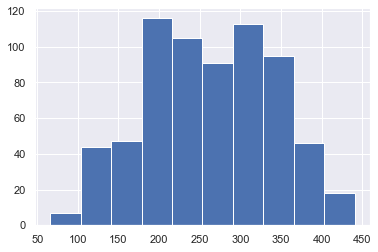

In [102]:
loan['score'].hist()

In [103]:
loan.shape

(682, 16)